In [1]:
import logging
from typing import Optional, Any, List, Dict

import pandas as pd
import numpy as np
import xgboost as xgb
import shap
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report
from dascripts import *


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

/home/nguyentp2/miniconda3/envs/dascripts/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Hello from dascripts! You have imported the following functions:
- Plot: decorate, hist, scatter
- Data processing: merge, DFEncoder
Have fun with your data analysis!



In [2]:
def train_xgboost(
    X_train: Any,
    y_train: Any,
    params: Dict[str, Any],
    X_val: Any=None,
    y_val: Any=None,
    pred_Xs: Optional[List]=None,
    num_boost_round: int=100,
    early_stopping_rounds: int=10,
):
    logger.info("XGBoost training")
    logger.debug(f"Training parameters: {params}")
    logger.debug(f"Training data shape: {X_train.shape}, Labels shape: {y_train.shape}")
    dtrain = xgb.DMatrix(X_train, label=y_train)
    if X_val is None or y_val is None:
        logger.warning("Validation data not provided, skipping validation.")
        dval = dtrain
        evals = [(dtrain, "train")]
    else:
        logger.debug(f"Validation data shape: {X_val.shape}, Labels shape: {y_val.shape}")
        dval = xgb.DMatrix(X_val, label=y_val)
        evals = [(dtrain, "train"), (dval, "eval")]

    logger.info("Run XGBoost training")
    train_hist = {}
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=evals,
        evals_result=train_hist,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=True,
    )
    train_result = {
        "model": model,
        "train_hist": train_hist,
        "best_iteration": model.best_iteration,
        "best_score": model.best_score,
    }
    if pred_Xs is not None:
        logger.info("Making predictions on provided datasets")
        preds = [model.predict(xgb.DMatrix(X)) for X in pred_Xs]
        train_result["preds"] = preds
    return train_result


In [3]:
def plot_training_history(train_result: Dict[str, Any]):
    # Extract training history
    train_hist = train_result["train_hist"]["train"]["logloss"]
    eval_hist = train_result["train_hist"].get("eval", {}).get("logloss", [])

    # best iteration
    best_iteration = train_result["best_iteration"]
    best_score = train_result["best_score"]

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(train_hist, label="Train Log Loss", color="blue")
    if eval_hist:
        ax.plot(eval_hist, label="Eval Log Loss", color="orange")
    ax.axvline(x=best_iteration, color='red', linestyle='--', label =f"Best Iteration: {best_iteration} ({best_score:.4f})")
    ax.set_title("XGBoost Training History")
    ax.set_xlabel("Boosting Rounds")
    ax.set_ylabel("Log Loss")
    ax.legend()
    return fig, ax

# Binary Classification

In [4]:
df = pd.read_csv("../inputs/titanic.csv")
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
encoders = DFEncoder(
    ord_cols=["Cabin", "Embarked"], 
    ohe_cols=["Pclass", "Sex"], 
).fit(train_df)
train_df_encoded = encoders.transform(train_df)
val_df_encoded = encoders.transform(val_df)

In [5]:
train_df_encoded.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_old,Embarked_old,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
331,332,0,1,"Partner, Mr. Austen",male,45.5,0,0,113043,28.5000,45,2,C124,S,1,0,0,0,1
733,734,0,2,"Berriman, Mr. William John",male,23.0,0,0,28425,13.0000,-1,2,NaN,S,0,1,0,0,1
382,383,0,3,"Tikkanen, Mr. Juho",male,32.0,0,0,STON/O 2. 3101293,7.9250,-1,2,NaN,S,0,0,1,0,1
704,705,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,350025,7.8542,-1,2,NaN,S,0,0,1,0,1
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,-1,2,NaN,S,0,0,1,1,0


In [6]:
train_df_encoded.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_old',
       'Embarked_old', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male'],
      dtype='object')

In [7]:
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.1,
    "max_depth": 6,
    "verbosity": 0,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "max_delta_step": 1,  # Dealing with class imbalance
}

feature_cols = ["Fare", 'Cabin', 'Embarked', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male']
train_result = train_xgboost(
    X_train=train_df_encoded[feature_cols],
    y_train=train_df_encoded['Survived'],
    X_val=val_df_encoded[feature_cols],
    y_val=val_df_encoded['Survived'],
    params=params,
    pred_Xs=[val_df_encoded[feature_cols]],
    num_boost_round=100,
    early_stopping_rounds=10,
)

2025-08-21 15:57:50,855 - __main__ - INFO - XGBoost training
2025-08-21 15:57:51,981 - __main__ - INFO - Run XGBoost training


[0]	train-logloss:0.63368	eval-logloss:0.65809
[1]	train-logloss:0.60963	eval-logloss:0.63618
[2]	train-logloss:0.58839	eval-logloss:0.61714
[3]	train-logloss:0.56639	eval-logloss:0.59756
[4]	train-logloss:0.54539	eval-logloss:0.58091
[5]	train-logloss:0.53162	eval-logloss:0.56659
[6]	train-logloss:0.51493	eval-logloss:0.55176
[7]	train-logloss:0.49867	eval-logloss:0.53763
[8]	train-logloss:0.48614	eval-logloss:0.52685
[9]	train-logloss:0.47345	eval-logloss:0.51674
[10]	train-logloss:0.46000	eval-logloss:0.50764
[11]	train-logloss:0.44729	eval-logloss:0.50273
[12]	train-logloss:0.43642	eval-logloss:0.49977
[13]	train-logloss:0.42591	eval-logloss:0.49189
[14]	train-logloss:0.41851	eval-logloss:0.48509
[15]	train-logloss:0.40988	eval-logloss:0.47858
[16]	train-logloss:0.40304	eval-logloss:0.47495
[17]	train-logloss:0.39777	eval-logloss:0.47093
[18]	train-logloss:0.39243	eval-logloss:0.46631
[19]	train-logloss:0.38618	eval-logloss:0.46372
[20]	train-logloss:0.38003	eval-logloss:0.46065
[2

2025-08-21 15:57:52,269 - __main__ - INFO - Making predictions on provided datasets


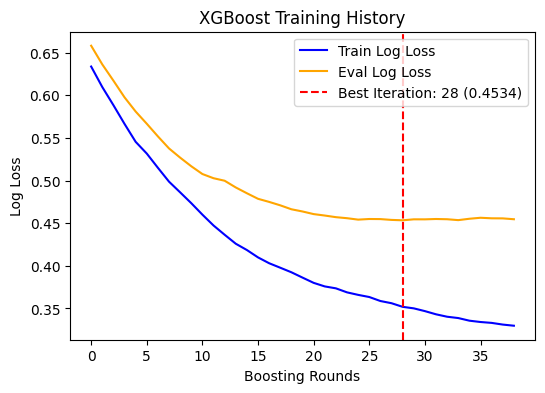

In [8]:
fig, ax = plot_training_history(train_result)

In [9]:
val_pred = train_result["preds"][0]
val_pred.shape

(179,)

In [10]:
val_report = classification_report(val_df_encoded['Survived'], (val_pred > 0.5).astype(int))
print(val_report)

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       105
           1       0.83      0.66      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179



## SHAP explanation

In [18]:
val_pred = train_result["preds"][0]
val_pred.shape

(179,)

In [19]:
explainer = shap.TreeExplainer(train_result["model"], feature_names=feature_cols)
explanation = explainer(xgb.DMatrix(val_df_encoded[feature_cols]))
shap_values = explanation.values
shap_values.shape

(179, 8)

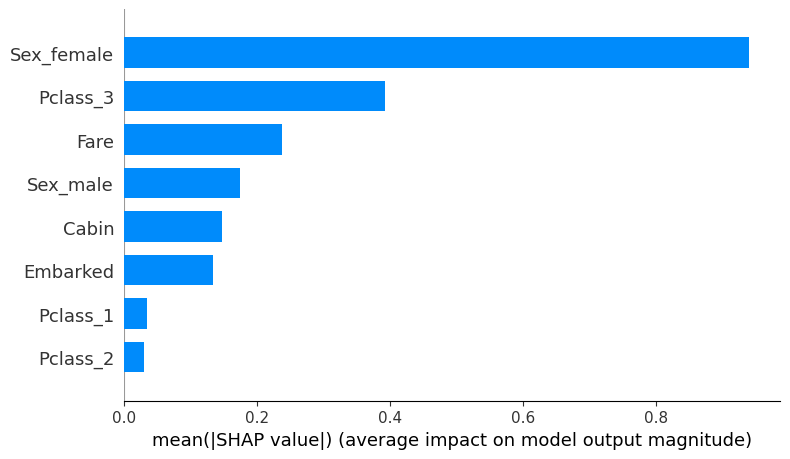

In [20]:
shap.summary_plot(shap_values, val_df_encoded[feature_cols], plot_type="bar")

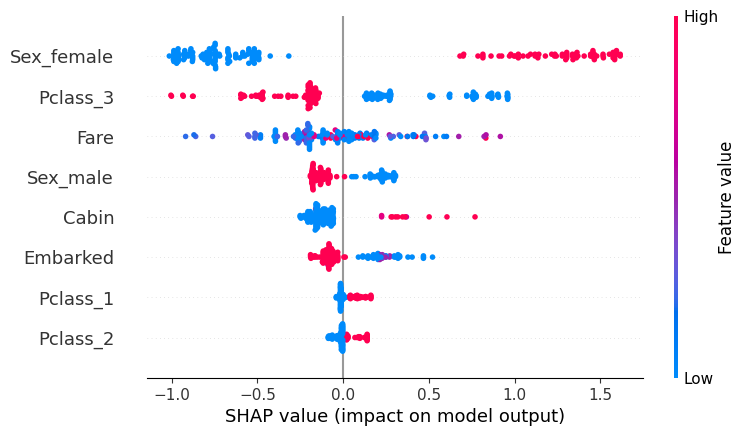

In [21]:
shap.plots.beeswarm(explanation)

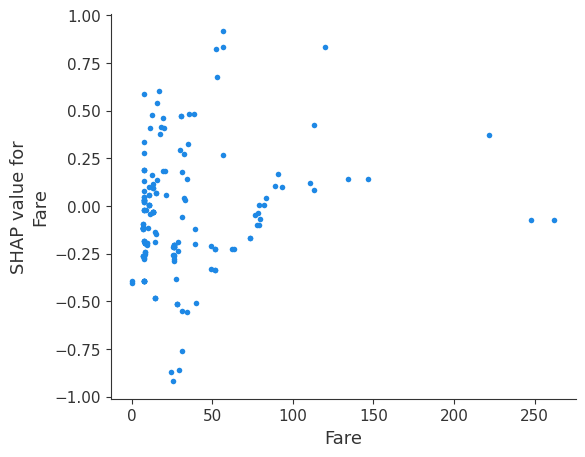

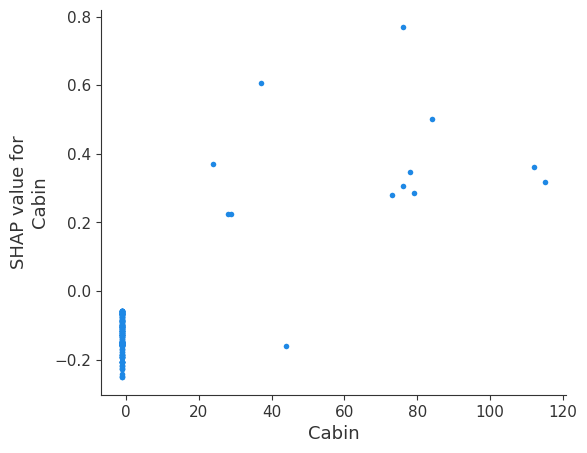

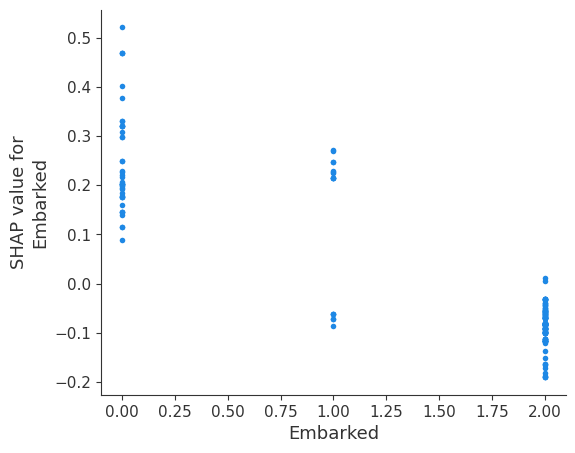

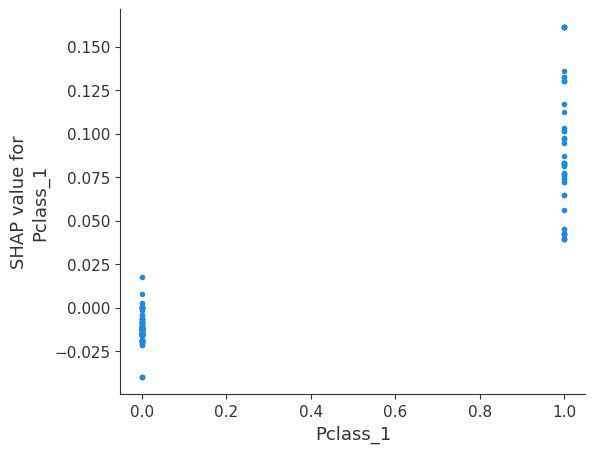

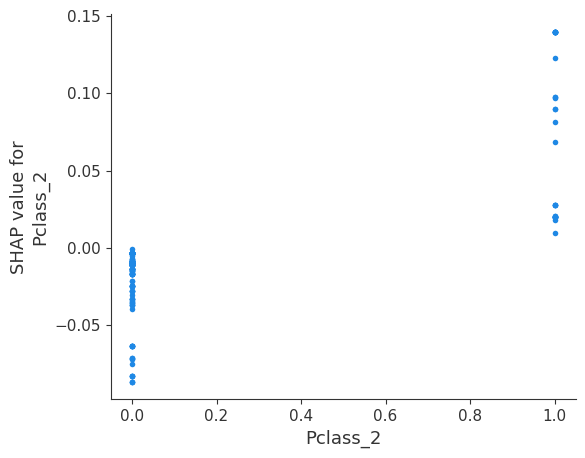

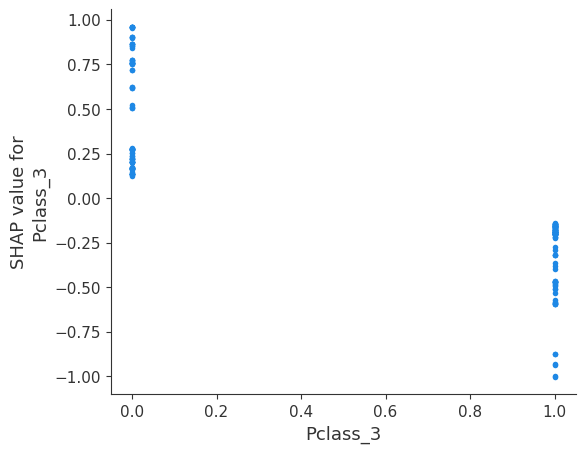

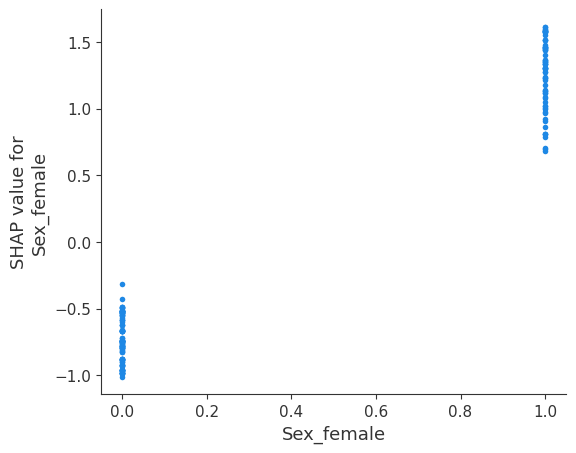

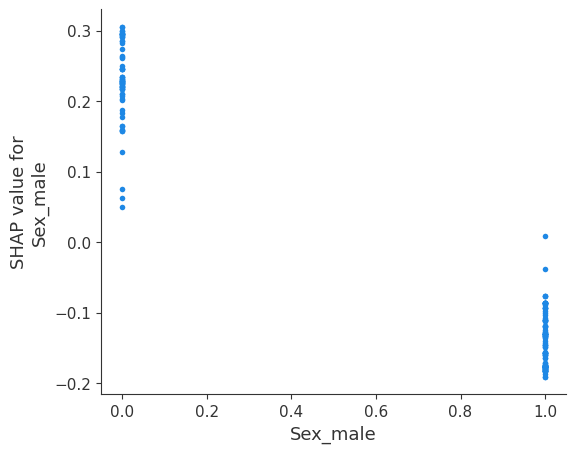

In [22]:
for name in feature_cols:
    shap.dependence_plot(name, shap_values, val_df_encoded[feature_cols], interaction_index=None)